## Filozofie
- Jednoduchý programovací jazyk GNU Octave.
- Bez snahy o solidní softwarový design.
- Bez optimalizace kódu.
- Proměnné a konstanty zaváděny těsně před prvním použitím.

## Co chceme řešit?
Úlohu 2D lineární elasticity.

## Jaké vstupy potřebujeme?
Definovat geometrii, materiálové parametry, okrajové podmínky.

1. Pro definovanou geometrii potřebujeme vytvořit výpočtovou síť. Síť reprezentujeme dvěma dvourozměrnými poli: polem souřadnic uzlů `X` a polem konektivity elementů `IEN`. Tyto pole můžeme pro jednoduché oblasti vytvořit ručně, ale pro složitější geometrie je užitečné použít tzv. síťovač, např. [Gmsh](https://gmsh.info).

```
Vytvoř vstupní soubor pro Gmsh `nosnik.geo`, pro 2D obdélník o délce L = 1 m a šířce b = sqrt(A) m, kde průřez A = 0.1 m^2. Počátek souřadnic je v levém horním rohu a souřadnice b míří ve směru +x a L ve směru -y. Obdélník vysíťuj třemi lineárními quad elementy ve směru y.
```

<center>
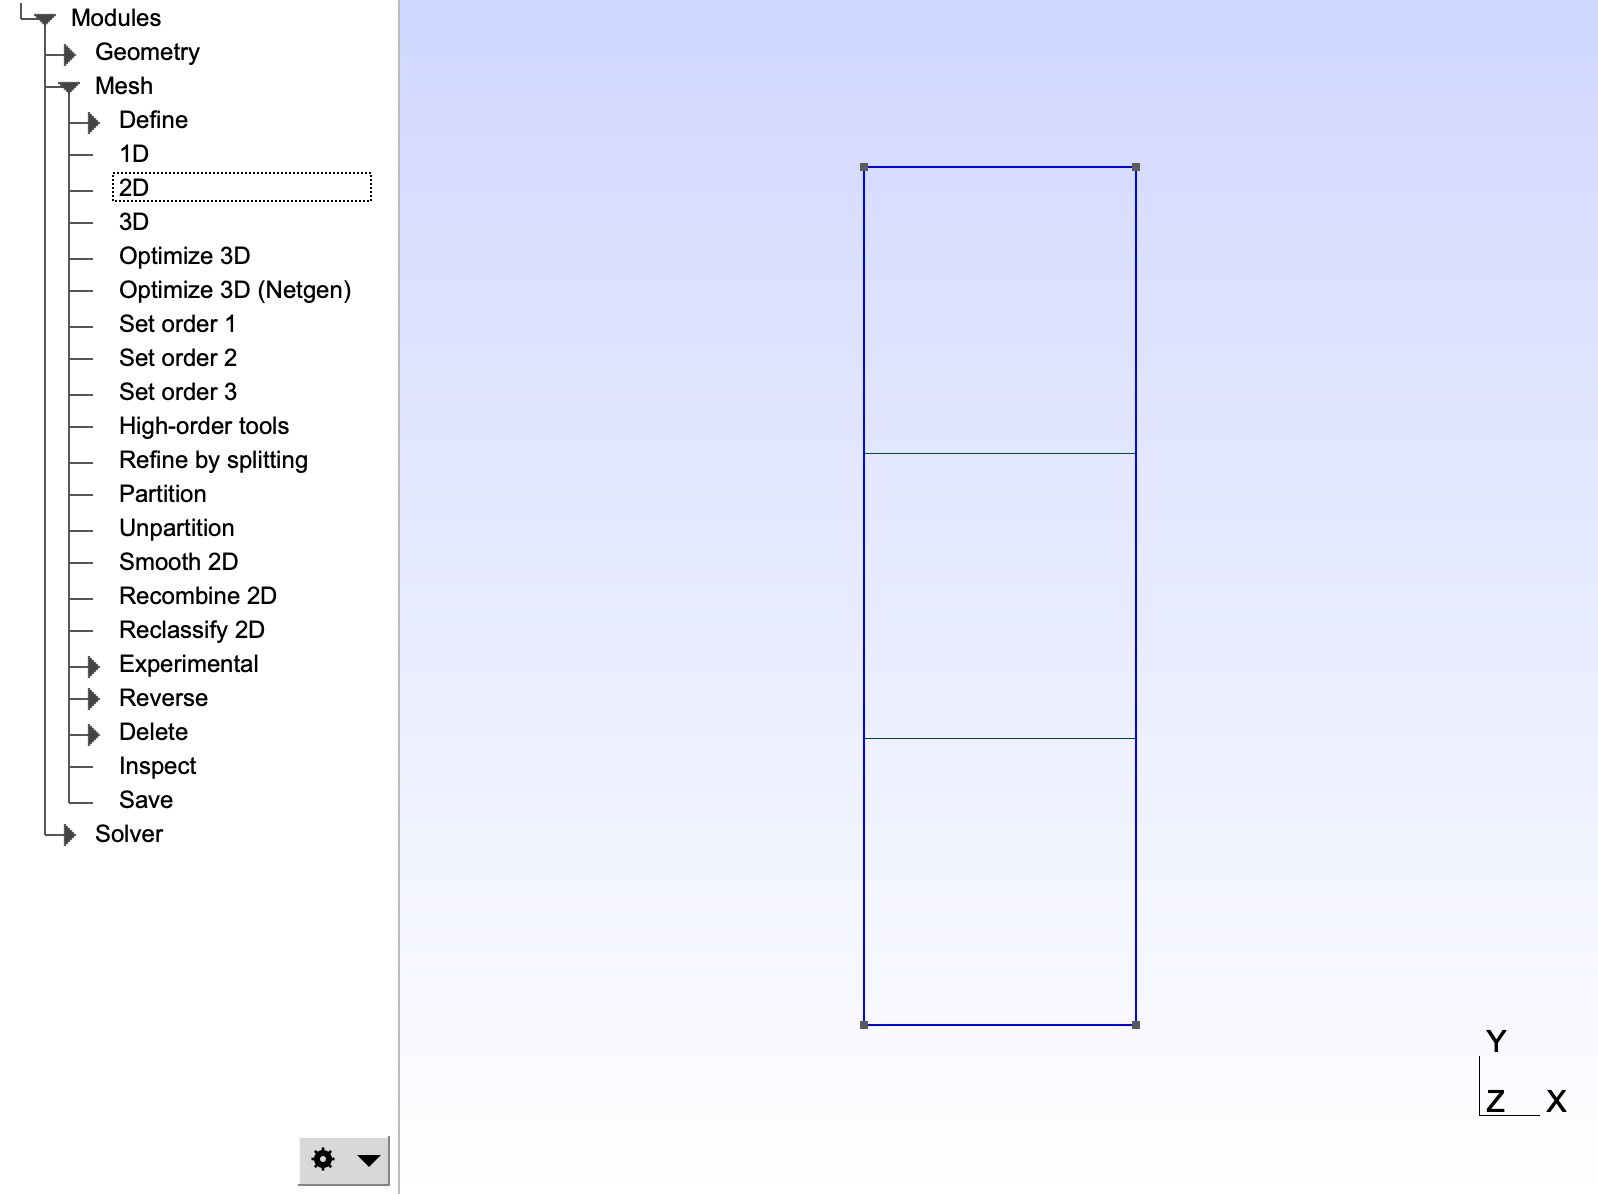
</center>

In [3]:
warning('off', 'Octave:deprecated-option'); graphics_toolkit('gnuplot'); format compact;



The gnuplot graphics toolkit is not actively maintained and has a number
of limitations that are unlikely to be fixed.  Communication with gnuplot
uses a one-directional pipe and limited information is passed back to the
Octave interpreter so most changes made interactively in the plot window
will not be reflected in the graphics properties managed by Octave.  For
example, if the plot window is closed with a mouse click, Octave will not
be notified and will not update its internal list of open figure windows.
The qt toolkit is recommended instead.


## Souřadnice uzlových bodů


In [4]:
nsd = 2; % Number of Spatial Dimensions
nosnik;
X = msh.POS(:,1:nsd)'




X =
        0   0.3162   0.3162        0   0.3162   0.3162        0        0
        0        0  -1.0000  -1.0000  -0.3333  -0.6667  -0.6667  -0.3333



## Pole konektivity


In [5]:
nen = 4; % Number of Element Nodes
IEN = msh.QUADS(:,1:nen)'



IEN =
   1   8   7
   2   5   6
   5   6   3
   8   7   4



## Co dál?

Slabá formulace statické úlohy lineární elasticity (bez objemových sil):
$$
\int_{\Omega}\delta\boldsymbol{\varepsilon}:\boldsymbol{\sigma}\,\textnormal{d}V-\int_{\Gamma_{\textnormal{N}}}\delta\boldsymbol{u}\cdot\bar{\boldsymbol{t}}\,\textnormal{d}S=0
$$
$\newcommand{\Aop}{\mathop{\vphantom{\sum}\vphantom{\rule{0pt}{2.5ex}}\smash{\lower{1.0ex}{\text{{\huge A}}}}}}$
a její MKP diskretizace:
$$
\delta\mathbf{u}^{\mathsf{T}}
\left\{ \left[\Aop_{el=1}^{n_{\textnormal{el}}}\int_{\Omega_{el}}\mathbf{B}^{\mathsf{T}}\mathbf{D}\mathbf{B}\,\textnormal{d}V_{el}\right]\mathbf{u}-\Aop_{el=1}^{n_{\textnormal{el}}}\left[\int_{\Gamma_{\textnormal{N}}^{e}}\mathbf{N}^{\mathsf{T}}\bar{\mathbf{t}}\,\textnormal{d}S_{el}\right]\right\} =0
$$
vede na lineární systém algebraický rovnic:
$$
\mathbf{K}\mathbf{u}-\mathbf{f}=\mathbf{0}
$$
kde:
$$
\mathbf{K}= 
\Aop_{el=1}^{n_\textnormal{en}}
\sum_{g}\mathbf{B}_{g}^{\mathsf{T}}\mathbf{D}\mathbf{B}_{g}w_{g}\left\Vert J_{g}\right\Vert ,\qquad
\mathbf{f}=
\Aop_{el=1}^{n_\textnormal{en}}
\sum_{g}\mathbf{N}^{\mathsf{T}}\bar{\mathbf{t}}_{g}w_{g}\left\Vert J_{g}^{\textnormal{s}}\right\Vert 
$$
### Co budeme potřebovat:
1. Sestavení globání matice a vektoru
2. Gaussova inetgrace
3. Matice tvarových funkcí $\mathbf{N}$
4. Operátorová matice $\mathbf{B}$
5. Matice materiálové tuhosti $\mathbf{D}$

## 1. Sestavení globání matice a vektoru

Nejprve si zvolíme, že neznámé složky posunutí pro jednotlivé uzly sítě budeme řadit ve vektoru řešní $\mathbf{u}$ takto:

$$
\begin{array}{c|ccccccccc}
i & 1 & 2 & 3 & 4 & 5 & 6 & \cdots & (n_{\textnormal{np}}\times n_{\textnormal{nd}})-1 & n_{\textnormal{np}}\times n_{\textnormal{nd}}\\
\hline
u_i & u_{1} & v_{1} & u_{2} & v_{2} & u_{3} & v_{3} & \cdots & u_{\textnormal{nnp}} & v_{\textnormal{nnp}}
\end{array}
$$

Vidíme, že délka vektoru $\mathbf{u}$ je součin počtu uzlů sítě `nnp` a počtu stupňů volnosti uzlu `nnd`, který je pro náš 2D případ roven 2.

Abychom se mohli snadněji odkazovat mezi globálními čísli uzlů $A\in\left[1,\ldots n_{\textnormal{np}}\right]$ a čísly rovnic jim odpovídajícími $eq\in\left[1,\ldots n_{\textnormal{eq}}\right]$, kde  $n_{\textnormal{eq}}=n_{\textnormal{np}}\times n_{\textnormal{nd}}$, zavedeme další pomocné pole konektivity `ID` takto: 

$$
\mathtt{ID} = \left[\begin{array}{ccccc}
1 & 3 & 5 & \cdots & n_{\textnormal{eq}} - 1 \\
2 & 4 & 6 & \ldots & n_{\textnormal{eq}}
\end{array}\right]
$$

Vidíme, že `A`-tý sloupec pole `ID` odpovídá `A`-tému globálnímu uzlu. Řádky v tomto `A`-tém sloupci obsahují odpovídající čísla neznámých složek vektoru posunutí $\mathbf{u}$.

Pole `ID` bychom mohli implementovat pomocí cyklu a indexové aritmetiky. Pro jednoduchost však využijeme vestavěné funkci `reshape()`, která 1D pole čísel rovnic převede na 2D pole, přesně jak jsme si definovali:

In [10]:
nnp = size(X,2);   % Number of Nodal Points
nnd = nsd;         % Number of Nodal DOFs =nsd=2(ux, uy)
neq = nnp * nnd;   % Number od EQuations
ID = reshape(1:nnp*nnd, nnd, [])





ID =
    1    3    5    7    9   11   13   15
    2    4    6    8   10   12   14   16



## 1. Sestavení globání matice a vektoru

Na nejvyšší úrovni se provádí proces sestavení $\Aop_{el=1}^{n_\textnormal{en}}$ globální matice tuhosti $\mathbf{K}$ a globálního vektoru pravé strany $\mathbf{f}$ z lokálních matic $\mathbf{K}_{el}$ a lokálních vektorů $\mathbf{f}_{el}$.

Následující fragment kódu ukazuje proces sestavení jako cyklus přes všechny elementy `nel`, ve kterém se z pole konektivity `IEN` získají globální čísla úzlů `A` elementu `el`. Pro ty se následně z pole `ID` získají čísla rovnic. Protože `ID` je dvourozměrné pole, `eq` je také dvourozměrné. Abychom jej mohli použít jako řez globální maticí a vektore, použijeme opět funkci `reshape()` a převedeme jej na jednorozměrný vektor indexů. V závěru for cyklu už jen snadno **kumulujeme** příspěvky z lokální matice a vektoru.

In [17]:
K = sparse(neq, neq);
f = zeros(neq, 1);

nel = size(IEN,2); % Number of ELement
for el = 1:nel
    Ke = zeros(nen*nnd,nen*nnd);
    fe = zeros(nen*nnd,1);
    
    A = IEN(:,el);
    eq = ID(:,A);
    eq = reshape(eq, [], 1);
    
    K(eq, eq) = K(eq, eq) + Ke;
    f(eq) = f(eq) + fe;
end

## 2. Gaussova inetgrace

Pro výpočet lokální matice tuhosti $\mathbf{K}_{el}$ a lokálníhi vektoru pravé strany $\mathbf{f}_{el}$ potřebujeme numerickou integraci přes objem elementu (povrch

In [ ]:
for el = 1:nel
    Ke = zeros(nen*nnd,nen*nnd);
    for g = 1:ngp
        N = evalBulkShapeFunctions( gp(:,g) );
        dN_dXi = evalBulkShapeFunctionsDerivatives( gp(:,g) );
        Xe = X(:, IEN(:,el) );
        Je = Xe * dN_dXi';
        j = det(Je);
        dN_dX = inv(Je) * dN_dXi;
        Be = createMatrixB(dN_dX);

        Ke += Be' * D * Be gw(g) * j
    end
end

In [ ]:
for el = 1:nel
    Ke = zeros(nen*nnd,nen*nnd);
    for g = 1:ngp
        N = evalBulkShapeFunctions( gp(:,g) );
        dN_dXi = evalBulkShapeFunctionsDerivatives( gp(:,g) );
        Xe = X(:, IEN(:,el) );
        Je = Xe * dN_dXi';
        j = det(Je);
        dN_dX = inv(Je) * dN_dXi;
        Be = createMatrixB(dN_dX);

        Ke += Be' * D * Be gw(g) * j
    end
end

## Matice materiálové tuhosti $\mathbf{D}$

Matice materiálové tuhosti je lineární operátor, který vektor přetvoření $\left\{ \boldsymbol{\varepsilon}\right\}$ zobrazí na vektor napětí $\left\{ \boldsymbol{\sigma}\right\}$: 
$$
\left\{ \boldsymbol{\sigma}\right\} =\mathbf{D}\left\{ \boldsymbol{\varepsilon}\right\} 
$$
podobně jako to dělá konstanta úměrnosti (Youngův modul pružnosti) $E$ v 1D podobě Hookeova zákona: 
$$
\sigma=E\varepsilon
$$
Ve 2D je potřeba rozlišovat mezi případem rovinné **deformace** a rovinné **napjatosti** viz poznámky nebo následující prompt pro LLM.

**Prompt:**
```
Dej mi matici materiálové tuhosti D pro případ rovinné deformace zapsanou v syntaxi GNU Octave.
```

In [ ]:
E = 210e9;   % Youngův modul [Pa]
nu = 0.3;    % Poissonovo číslo [-]
D = E / ((1 + nu) * (1 - 2*nu)) * [1-nu,  nu,       0;
                                   nu,    1-nu,     0;
                                   0,     0,    (1-2*nu)/2];

## Operátorová matice $\mathbf{B}$

Operátorová matice $\mathbf{B}$ zobrazí vektor posunutí $\mathbf{u}$ na vektor přetvoření $\left\{ \boldsymbol{\varepsilon}\right\} $:
$$
\left\{ \boldsymbol{\varepsilon}\right\} =\mathbf{B}\mathbf{u}
$$
Pro 2D případ

$$
\left\{ \begin{array}{c}
\varepsilon_{x}\\
\varepsilon_{y}\\
\gamma_{xy}
\end{array}\right\} =\left[\begin{array}{cc}
\frac{\partial}{\partial x} & 0\\
0 & \frac{\partial}{\partial y}\\
\frac{\partial}{\partial y} & \frac{\partial}{\partial x}
\end{array}\right]\left\{ \begin{array}{c}
u\\
v
\end{array}\right\} =\left[\begin{array}{cc}
\frac{\partial}{\partial x} & 0\\
0 & \frac{\partial}{\partial y}\\
\frac{\partial}{\partial y} & \frac{\partial}{\partial x}
\end{array}\right]\left\{ \begin{array}{c}
\sum_{a=1}^{n_{\textnormal{en}}}N_{a}u_{a}\\
\sum_{a=1}^{n_{\textnormal{en}}}N_{a}v_{a}
\end{array}\right\} 
$$

$$
\left\{ \begin{array}{c}
\varepsilon_{x}\\
\varepsilon_{y}\\
\gamma_{xy}
\end{array}\right\} =\left[\left[\begin{array}{cc}
\frac{\partial N_{1}}{\partial x} & 0\\
0 & \frac{\partial N_{1}}{\partial y}\\
\frac{\partial N_{1}}{\partial y} & \frac{\partial N_{1}}{\partial x}
\end{array}\right]\cdots\left[\begin{array}{cc}
\frac{\partial N_{n_{\textnormal{en}}}}{\partial x} & 0\\
0 & \frac{\partial N_{n_{\textnormal{en}}}}{\partial y}\\
\frac{\partial N_{n_{\textnormal{en}}}}{\partial y} & \frac{\partial N_{n_{\textnormal{en}}}}{\partial x}
\end{array}\right]\right]\left\{ \begin{array}{c}
u_{a}\\
v_{a}\\
\vdots\\
u_{n_{\textnormal{en}}}\\
v_{n_{\textnormal{en}}}
\end{array}\right\} 
$$